### Initializations

In [2]:
import urllib
response = urllib.urlopen('http://deeplearning.net/tutorial/code/utils.py')
content = response.read()

target = open('utils.py', 'w')
target.write(content)
target.close()

### Load all Neural Network Libraries

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import Image
from utils import tile_raster_images
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### RBM Layers

In [5]:
# Visible Layer
vb = tf.placeholder('float', [784])

# Hidden Layer
hb = tf.placeholder('float', [500])

# Weights
W = tf.placeholder('float', [784, 500])

### RBMs in DeepLearning

### Forword Pass

In [9]:
v0 = tf.placeholder('float', [500, None])

# Probablities of the Hidden Units
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)

h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

In [22]:
X = tf.placeholder("float", [None, 784])

# Probabilities of the hidden units
_h0= tf.nn.sigmoid(tf.matmul(X, W) + hb)  

# Sample_h_given_X
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) 

In [23]:
with tf.Session() as sess:
    a = tf.constant([0.7, 0.1, 0.8, 0.2])
    print sess.run(a)
    b = sess.run(tf.random_uniform(tf.shape(a)))
    print b
    
    print sess.run(a-b)
    print sess.run(tf.sign( a * b))
    print sess.run(tf.nn.relu(tf.sign( a * b)))

[ 0.69999999  0.1         0.80000001  0.2       ]
[ 0.51173818  0.09827387  0.06485808  0.67742562]
[ 0.18826181  0.00172613  0.73514193 -0.47742563]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]


### Backward Pass (Reconstruction)

In [24]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

### Reconstrunction Steps:
* Get one data point from dataset like x and pass it through the net
* Pass 0: (x)  -> (x- _h0) -> (h0 - v1) (v1 is reconstruction of the first pass)
* Pass 1: (v1) -> (v1- h1) -> (_h0 - v2) (v2 is reconstruction of the second pass)
* Pass 2: (v2) -> (v2- h2) -> (_h1 - v3) (v3 is reconstruction of the third pass)
* Pass n: (vn) -> (vn- hn+1) -> (_hn - vn+1) (vn is reconstruction of the nth pass)


In [25]:
# Sampling
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [26]:
# Error Function 
err = tf.reduce_mean(tf.square(X - v1))

In [27]:
cur_w = np.zeros([784, 500], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)
prv_w = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [28]:
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48128307

Epoch: 0 reconstruction error: 0.063921
Epoch: 1 reconstruction error: 0.054201
Epoch: 2 reconstruction error: 0.050466
Epoch: 3 reconstruction error: 0.047524
Epoch: 4 reconstruction error: 0.046209


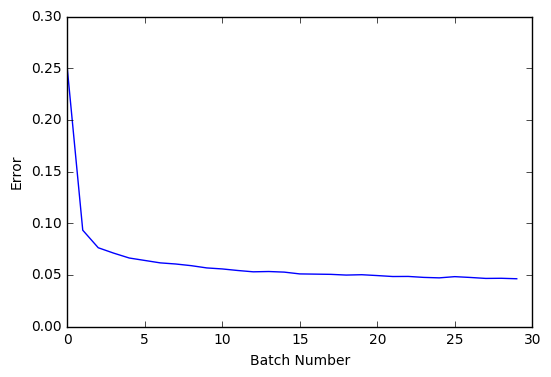

In [29]:
# Training Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print 'Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1]
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

In [30]:
# After Training
uw = weights[-1].T

# Weight matrix of shape (500,784)
print uw 

[[-0.21000649 -0.21504223 -0.26500863 ..., -0.2550025  -0.28000632
  -0.25501549]
 [-0.3372744  -0.26379177 -0.43616116 ..., -0.37426627 -0.38981336
  -0.35953274]
 [-0.2100049  -0.21503192 -0.26500401 ..., -0.25500217 -0.28000447
  -0.25501692]
 ..., 
 [-0.21019979 -0.21507716 -0.26501867 ..., -0.25502142 -0.28001082
  -0.25502473]
 [-0.21141155 -0.22365056 -0.26512653 ..., -0.25538263 -0.28072554
  -0.25506973]
 [-0.21002947 -0.2150608  -0.2650362  ..., -0.25501922 -0.28004143
  -0.25506285]]


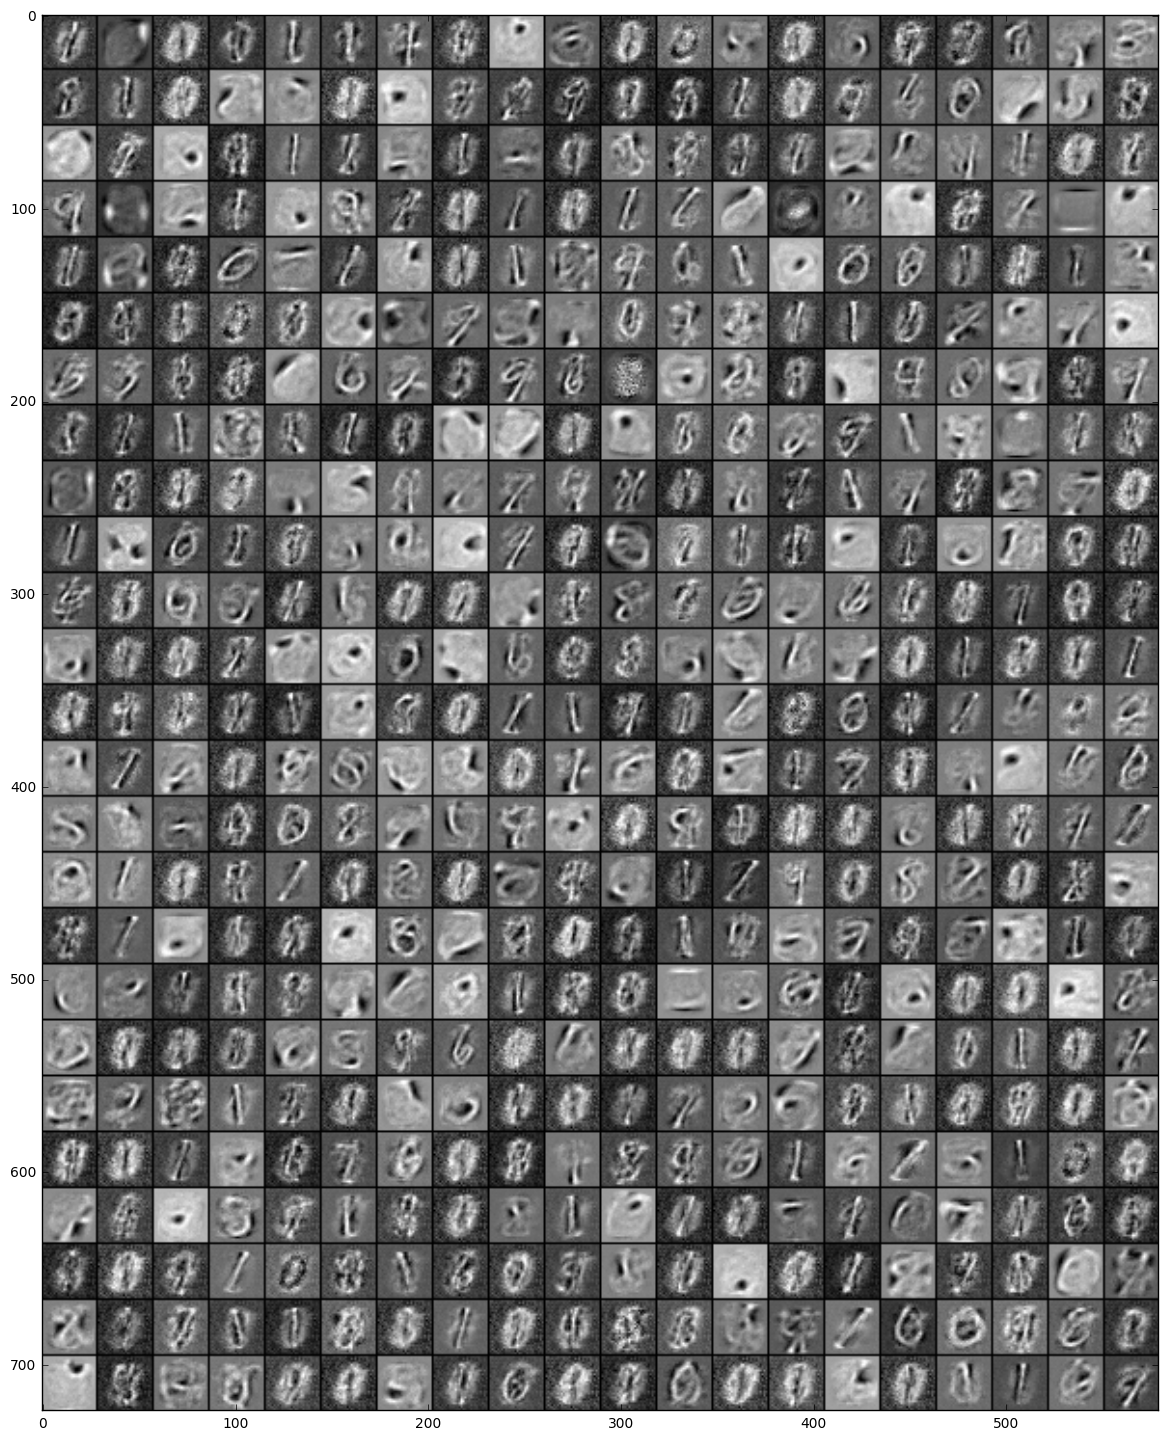

In [31]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(25, 20), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(25, 20), tile_spacing=(1, 1)))

### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

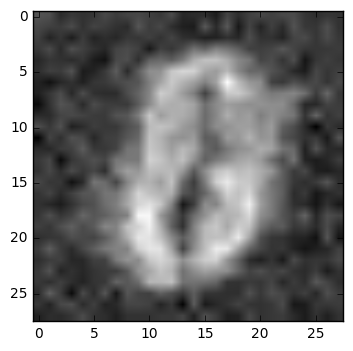

In [32]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X=cur_w.T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))

### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

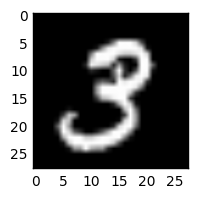

In [33]:
sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)

# Experiment different colormaps (Greys,winter,autumn)
imgplot.set_cmap('gray')  

In [34]:
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

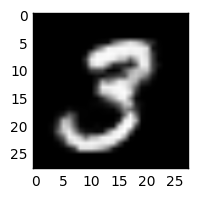

In [35]:
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 